## Credit Card Fraud Detection

### Content

This dataset consists of credit card transaction details, with a binary target variable representing whether the transaction is fraudulent or legitimate. The aim is to develop a predictive model for credit card fraud detection that can accurately identify fraudulent transactions, enabling timely intervention and safeguarding against potential financial losses.

1. [Introduction](#Introduction:)
2. [Import libraries](#Import-libraries)
3. [Exploratory data analysis](#4.-Exploratory-data-analysis)
4. [Model implementation](#Model-implementation)
    - KNeighborsClassifier
    - RandomForestClassifier
    - XGBClassifier
    - LGBMClassifier

### Introduction

#### Details of features:

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time.

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amt** - amount of the transaction in local currency.

* **nameOrig** - customer who started the transaction

* **oldBalanceOrg** - initial balance before the transactions

* **newBalanceOrig** - new balance after the transaction

* **nameDest** - customer who is the recipient of the transaction

* **oldBalanceDest** - initial balance of recipient before the transaction.
* **newBalanceDest** - new balance of recipient after the transaction.

* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation.

* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction

### Import libraries

In [24]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Import modules for data preprocessing and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Import modules for handling imbalanced datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

# Import machine learning models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Import TensorFlow for deep learning
import tensorflow as tf

# Set the visible CUDA device to '0'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Data source: https://www.kaggle.com/code/kartik2112/fraud-detection-on-paysim-dataset/input

In [2]:
# Read 'Fraud.csv' into a DataFrame and display the first few rows.
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Exploratory data analysis

In [3]:
# Summary statistics formatted with 2 decimals.
data.describe().applymap('{:,.2f}'.format)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90","833,883.10","855,113.67","1,100,701.67","1,224,996.40",0.00,0.00
std,142.33,"603,858.23","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94",0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.57",0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,"74,871.94","14,208.00",0.00,"132,705.66","214,661.44",0.00,0.00
75%,335.00,"208,721.48","107,315.18","144,258.41","943,036.71","1,111,909.25",0.00,0.00
max,743.00,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00


In [4]:
# Categorical summary statistics.
data.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [5]:
# Count missing values per column.
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Count unique values per column.
data.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

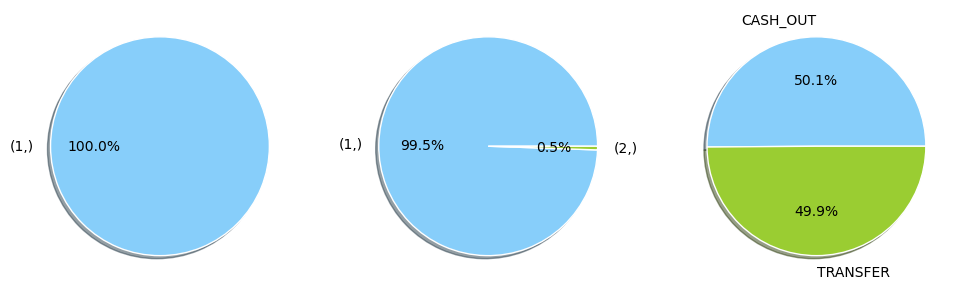

In [7]:
# Filter the 'data' DataFrame to create a new DataFrame containing only fraud data.
data_fraud = data[data['isFraud'] == 1]

# Count occurrences of each unique 'nameOrig' in the fraud data and the occurrences of each count value.
grouped_nameOrig = data_fraud[["nameOrig", "isFraud"]].groupby('nameOrig').count().value_counts()

# Count occurrences of each unique 'nameDest' in the fraud data and the occurrences of each count value.
grouped_nameDest = data_fraud[["nameDest", "isFraud"]].groupby('nameDest').count().value_counts()

# Count occurrences of each unique 'type' in the fraud data.
grouped_type = data_fraud[["type", "isFraud"]].groupby('type').count()

# Define a function 'plot' to create pie charts with labels and percentage values.
def plot(ind, values, labels):
    return axes[ind].pie(values, labels=labels, labeldistance=1.15,
                         wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
                         autopct='%1.1f%%', shadow=True,
                         colors=["lightskyblue", "yellowgreen"])

# Create a 1x3 subplot layout with a total figure size of (12, 4).
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

# Plot pie charts for 'grouped_nameOrig', 'grouped_nameDest', and 'grouped_type.isFraud' on the three subplots.
plot(0, grouped_nameOrig.values, grouped_nameOrig.index)
plot(1, grouped_nameDest.values, grouped_nameDest.index)
plot(2, grouped_type.isFraud, grouped_type.index)

# Display the plotted pie charts.
plt.show()


In [8]:
# Function to remove non-alphabetic characters and create a new column.
def char_separator(text):
    new_text = ""
    
    for char in text:
        if char.isalpha():
            new_text += char
        
    return new_text

data['nameOrigChar_DestChar'] = data['nameOrig'].apply(char_separator) + data['nameDest'].apply(char_separator)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrigChar_DestChar
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM


In [9]:
# Grouping data containing fraud based on 'nameOrigChar_DestChar',
# counting occurrences, and sorting in descending order.

data_nameOrigChar_DestChar = data[data['isFraud'] == 1] \
                                [['nameOrigChar_DestChar', 'isFraud']] \
                                .groupby("nameOrigChar_DestChar") \
                                .count().sort_values("isFraud",ascending= False)
data_nameOrigChar_DestChar

,isFraud
nameOrigChar_DestChar,
CC,8213


In [10]:
# Dropping 'nameOrig' and 'nameDest' columns from 'data' DataFrame
data.drop(['nameOrig', "nameDest"], axis=1, inplace=True)

# Creating dummy variables for categorical columns.
data_dummy = pd.get_dummies(data, columns=['type', 'nameOrigChar_DestChar'])
data_dummy

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameOrigChar_DestChar_CC,nameOrigChar_DestChar_CM
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,0,1,0,0,1
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,0,1,0,0,1
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,0,1,1,0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0,1,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,1,0,0,0,1,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,0,1,1,0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,1,0,0,0,1,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,0,1,1,0


In [11]:
# Splitting the dataset into features (X) and target variable (y)
X = data_dummy.drop('isFraud', axis=1)
y = data_dummy.isFraud

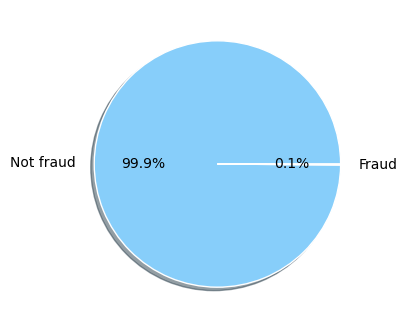

In [12]:
# Create a pie chart to visualize the distribution of the target variable 'y' (fraud vs. not fraud)
plt.figure(figsize=(12, 4))

# Using the 'value_counts()' method to count the occurrences of each unique value in 'y'
# and then extracting the values to plot in the pie chart
plt.pie(y.value_counts().values, labels=['Not fraud', 'Fraud'], labeldistance=1.15,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        autopct='%1.1f%%', shadow=True,
        colors=["lightskyblue", "yellowgreen"])

plt.show()

In [13]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=73)

In [14]:
# Creating two sampling techniques: SMOTE and RandomUnderSampler
# SMOTE: Oversampling method to balance the minority class (fraud) by generating synthetic samples
# RandomUnderSampler: Undersampling method to reduce the majority class (not fraud) by randomly removing samples

over = SMOTE(sampling_strategy=0.025)  # Setting the sampling strategy for SMOTE
under = RandomUnderSampler(random_state=42, sampling_strategy=0.5)  # Setting the sampling strategy for RandomUnderSampler

# Creating a pipeline to apply the sampling techniques in sequence
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Resampling the training data using the pipeline
# x_res: Resampled feature data (balanced X_train)
# y_res: Resampled target variable (balanced y_train)
x_res, y_res = pipeline.fit_resample(X_train, y_train)

# Counting the occurrences of each class in the resampled target variable 'y_res'
y_res.value_counts()

0    238290
1    119145
Name: isFraud, dtype: int64

In [15]:
# Creating an instance of MinMaxScaler to scale
scaler = MinMaxScaler()

In [16]:
# Scaling the training data
X_train_scaled = scaler.fit_transform(x_res)

# Scaling the testing data
X_test_scaled = scaler.transform(X_test)

### Model implementation

In [17]:
# Create a dictionary of machine learning models
models_dict = {
    "KNeighbors": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost":  XGBClassifier(),
    "LGB": LGBMClassifier()
}

In [18]:
# Create a dictionary of model parameters
params_dict = {
    "KNeighbors_params" : {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'metric': ['euclidean', 'manhattan']
    },
    
    "RandomForest_params" : {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample']
    },

    "XGBoost_params" : {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.1, 0.01, 0.001],
        'scale_pos_weight': [1, 5, 10]
    },

    "LGB_params" : {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.01, 0.001],
        'class_weight': ['balanced', None]
    }    
}    

In [19]:
def train_model(model, params, X_train, y_train, X_test, y_test):
    """
    Trains a model using the given parameters on the provided training data.

    Args:
        model: The machine learning model to train.
        params: The parameter grid to search over during training.
        X_train: The input features of the training data.
        y_train: The target labels of the training data.

    Returns:
        The trained model after performing grid search.

    """
    print("## " * 5, f"{model} started training ...", "## " * 5)
    
    # Perform grid search using cross-validation
    model_gscv = GridSearchCV(model, params)
    
    # Specify GPU device for training (optional)
    with tf.device('/GPU:0'):
        model_gscv.fit(X_train, y_train)
    
    # Print best parameters and score
    print("\n", "-" * 50)
    print("Best parameters:", model_gscv.best_params_)
    print("Best score:", model_gscv.best_score_)
    
    
    # Make predictions on test data and print classification report
    pred = model_gscv.predict(X_test_scaled)
    print("\n", "-" * 50)
    print("Classification report\n")
    print(classification_report(y_test, pred))
    
    return model_gscv

In [20]:
def result_plot(y_test, y_pred): 
    # Define the false positive rate and true positive rate for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # Define the AUC score for the ROC curve
    auc_score = roc_auc_score(y_test, y_pred)
    
    # Create a 1x2 subplot
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    
    # Plot the confusion matrix heatmap in the first subplot
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '.0f', cbar = False, cmap="Blues", ax = ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')
    ax[0].set_title('Confusion Matrix', fontsize=12)
    
    # Plot the ROC curve in the second subplot
    ax[1].plot(fpr, tpr, color='orange', label='ROC Curve (AUC = {:.2f})'.format(auc_score))
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='navy')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
    ax[1].legend()
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    plt.show()

## ## ## ## ##  KNeighborsClassifier() started training ... ## ## ## ## ## 

 --------------------------------------------------
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.9771986515030704

 --------------------------------------------------
Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1588602
           1       0.06      0.96      0.12      2053

    accuracy                           0.98   1590655
   macro avg       0.53      0.97      0.55   1590655
weighted avg       1.00      0.98      0.99   1590655



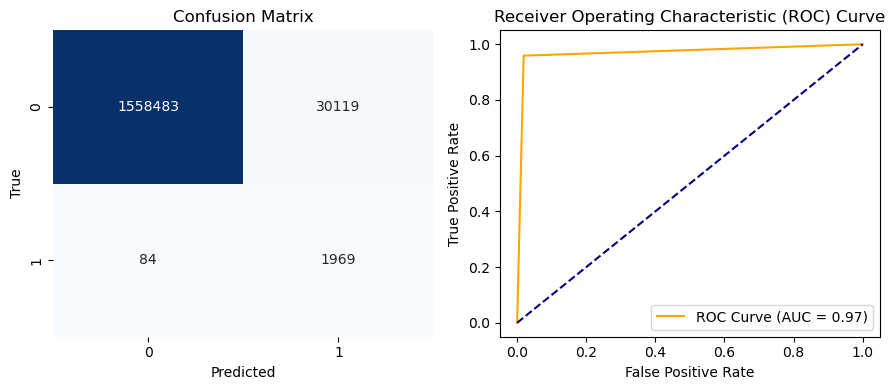

## ## ## ## ##  RandomForestClassifier() started training ... ## ## ## ## ## 

 --------------------------------------------------
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9870997524025349

 --------------------------------------------------
Classification report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1588602
           1       0.06      0.99      0.12      2053

    accuracy                           0.98   1590655
   macro avg       0.53      0.99      0.56   1590655
weighted avg       1.00      0.98      0.99   1590655



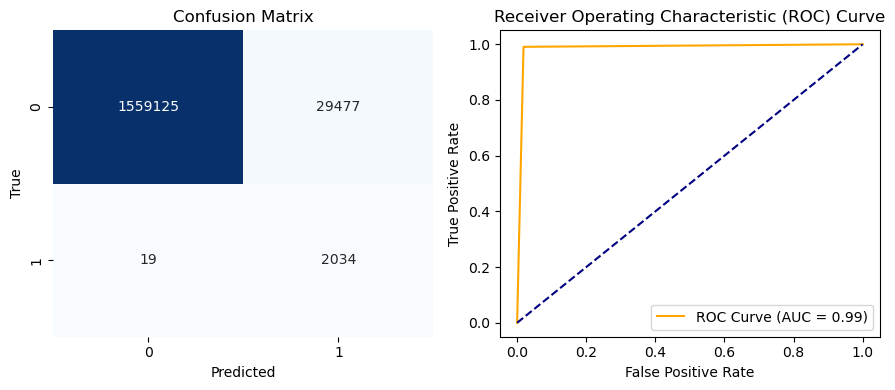

## ## ## ## ##  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) started training ... ## ## ## ## ## 

 --------------------------------------------------
Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'scale_pos_weight': 1}
Best score: 0.9983045868479584

 ---------

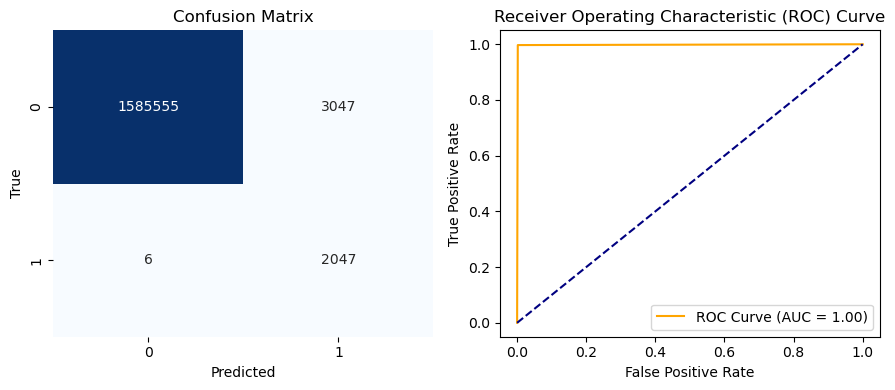

## ## ## ## ##  LGBMClassifier() started training ... ## ## ## ## ## 

 --------------------------------------------------
Best parameters: {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Best score: 0.9979296935107083

 --------------------------------------------------
Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.36      1.00      0.53      2053

    accuracy                           1.00   1590655
   macro avg       0.68      1.00      0.77   1590655
weighted avg       1.00      1.00      1.00   1590655



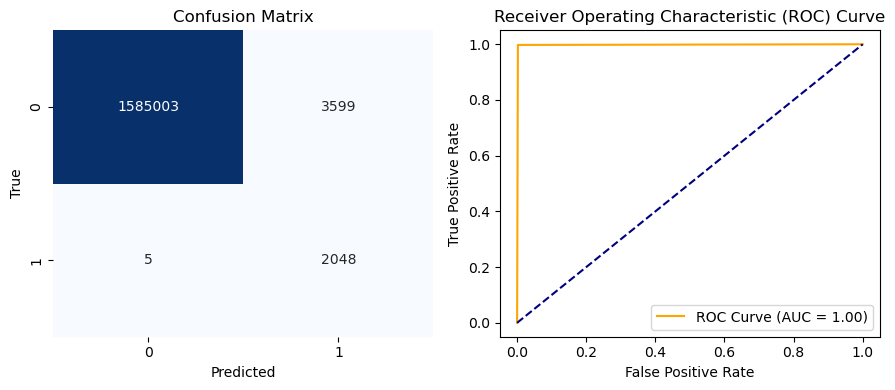

In [21]:
# Iterate over the models in the models_dict and train each model
for model in models_dict:
    # Train the model using train_model() function
    model_gscv = train_model(models_dict[model],
                             params_dict[model + "_params"],
                             X_train_scaled, y_res,
                             X_test_scaled, y_test)
    
    # Make predictions on the test data using the trained model
    pred = model_gscv.predict(X_test_scaled)
    
    # Update the models_dict with the trained model
    models_dict[model] = model_gscv
    
    # Plot the results and print a separator
    result_plot(y_test, pred)

In [25]:
# Save the trained models using pickle
for model in models_dict:
    # Open a file to write the model
    with open(f'{model}.pkl', 'wb') as file:
        # Use pickle to dump the model into the file
        pickle.dump(models_dict[model], file)